In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Check NumPy version compatibility
if int(np.__version__.split('.')[0]) >= 2:
    print(f"Warning: Detected NumPy {np.__version__}, imgaug is incompatible with NumPy 2.0+")
    print("Solution: Downgrade NumPy to version 1.x")
    print("Run command: pip install 'numpy<2.0'")
    print("Or: pip install numpy==1.26.4")

import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
try:
    from imgaug import augmenters as iaa
except (ImportError, AttributeError) as e:
    if "sctypes" in str(e) or "np.sctypes" in str(e):
        print("\nError: imgaug is incompatible with NumPy 2.0+")
        print("Solution: Downgrade NumPy")
        print("Run command: pip install 'numpy<2.0'")
        print("Or: pip install numpy==1.26.4")
    else:
        print("Warning: imgaug is not installed. Please run: pip install imgaug")
    raise

import random

Found 1964 image files (train: 1464, validate: 500)
Found 500 test files (test directory exists)
Data shape: x_data=(1964, 90, 90, 1), y_data=(1964, 4)

Test set loaded: (500, 90, 90, 1), (500, 4)

Training set: (1464, 90, 90, 1), (1464, 4)
Validation set: (500, 90, 90, 1), (500, 4)
Test set: (500, 90, 90, 1), (500, 4)

✓ Training and validation sets are separated to avoid data leakage

Data Count Summary
Training set:
  Number of images: 1464
  Number of labels: 1464
  Image shape: (90, 90, 1) (height, width, channels)
  Label shape: (4,) (4 values per label)

Validation set:
  Number of images: 500
  Number of labels: 500
  Image shape: (90, 90, 1) (height, width, channels)
  Label shape: (4,) (4 values per label)

Total dataset:
  Total images: 1964
  Total labels: 1964


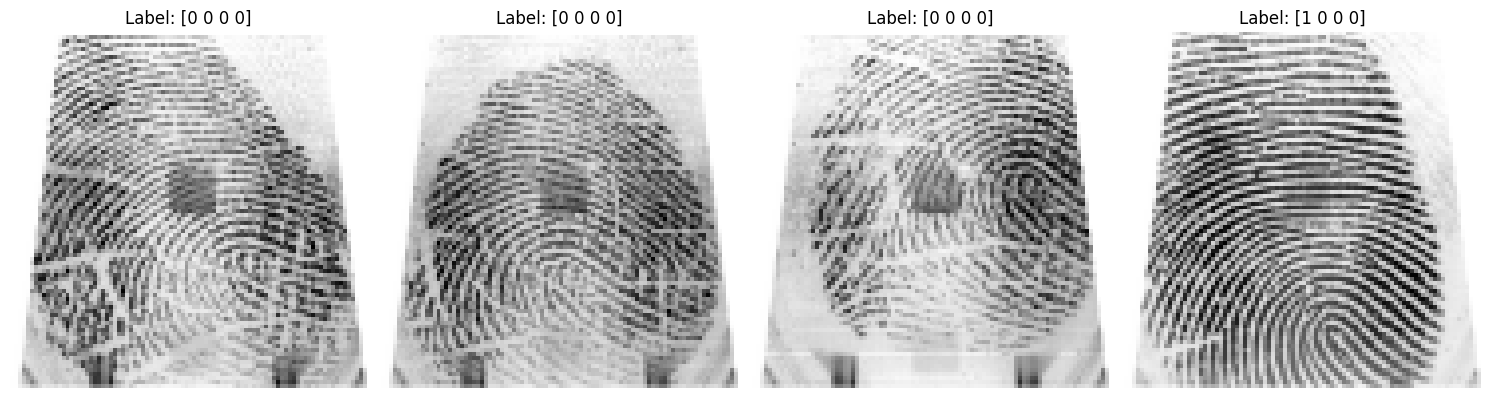

In [83]:
# ============================================
# Load Project-Data Dataset
# ============================================
import os
import glob
import cv2

def load_project_data(data_dir='Project-Data-Processed', img_size=(90, 90)):
    """
    Load Project-Data dataset
    Parameters:
        data_dir: Dataset directory path
        img_size: Target image size (height, width)
    Returns:
        x_data: Image data array (N, 90, 90, 1)
        y_data: Label data array (N, 4) - [subject_id(3), gender(1), left_right(1), finger(1)]
        file_paths: List of file paths corresponding to each image
    """
    # Define data directories
    train_dir = os.path.join(data_dir, 'train')
    validate_dir = os.path.join(data_dir, 'validate')
    test_dir = os.path.join(data_dir, 'test')
    
    # Collect all image files
    train_files = sorted(glob.glob(os.path.join(train_dir, '*.bmp')))
    validate_files = sorted(glob.glob(os.path.join(validate_dir, '*.bmp')))
    test_files = sorted(glob.glob(os.path.join(test_dir, '*.bmp'))) if os.path.exists(test_dir) else []
    
    all_files = train_files + validate_files
    print(f"Found {len(all_files)} image files (train: {len(train_files)}, validate: {len(validate_files)})")
    if test_files:
        print(f"Found {len(test_files)} test files (test directory exists)")
    
    # Store images, labels, and file paths
    images = []
    labels = []
    file_paths = []
    
    for file_path in all_files:
        # Read image (grayscale mode)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to read image {file_path}")
            continue
        
        # Resize image
        img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        
        # Add channel dimension (90, 90) -> (90, 90, 1)
        img_resized = np.expand_dims(img_resized, axis=-1)
        images.append(img_resized)
        file_paths.append(file_path)  # Save file path
        
        # Parse label from filename
        # Filename format: ID_R0_number.bmp or similar
        filename = os.path.basename(file_path)
        filename_no_ext = filename.replace('.bmp', '')
        parts = filename_no_ext.split('_')
        
        if len(parts) >= 1:
            # Extract subject_id (from first part of filename)
            subject_id = int(parts[0])
            # For other information, use default values if not explicitly identified
            # Can be adjusted based on actual filename format
            gender = 0  # Default value, can be adjusted based on actual data
            left_right = 0  # Default value, can be adjusted based on actual data
            finger = 0  # Default value, can be adjusted based on actual data
            
            # If filename contains more information, can parse here
            # For example: if format is ID_Gender_LR_Finger_number
            if len(parts) >= 2:
                # Can try to extract more information from filename
                pass
            
            label = np.array([subject_id, gender, left_right, finger], dtype=np.int32)
            labels.append(label)
        else:
            print(f"Warning: Unable to parse filename {filename}")
    
    # Convert to numpy arrays
    x_data = np.array(images, dtype=np.uint8)
    y_data = np.array(labels, dtype=np.int32)
    
    print(f"Data shape: x_data={x_data.shape}, y_data={y_data.shape}")
    return x_data, y_data, file_paths

# Load Project-Data dataset
# Note: Keep train and validate directories separated to avoid data leakage
x_data, label_data, file_paths = load_project_data('Project-Data', img_size=(90, 90))

# Method 1: Use train_test_split for random splitting (will mix together)
# x_train, x_val, label_train, label_val = train_test_split(
#     x_data, label_data, test_size=0.2, random_state=42
# )

# Method 2: Separate according to original directory structure (recommended, avoids data leakage)
# From the load_project_data function we know:
# - train_files has 1464 files
# - validate_files has 500 files
# According to loading order, first 1464 are training set, last 500 are validation set
num_train = 1464  # Can be seen from output
x_train = x_data[:num_train]
label_train = label_data[:num_train]
train_file_paths = file_paths[:num_train]  # Save training file paths
x_val = x_data[num_train:]
label_val = label_data[num_train:]
val_file_paths = file_paths[num_train:]  # Save validation file paths

# Load test set if it exists
x_test = None
label_test = None
test_file_paths = None
test_dir = os.path.join('Project-Data', 'test')
if os.path.exists(test_dir):
    test_files = sorted(glob.glob(os.path.join(test_dir, '*.bmp')))
    
    if test_files:
        test_images = []
        test_labels = []
        test_file_paths = []
        
        for file_path in test_files:
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_resized = cv2.resize(img, (90, 90), interpolation=cv2.INTER_AREA)
            img_resized = np.expand_dims(img_resized, axis=-1)
            test_images.append(img_resized)
            test_file_paths.append(file_path)
            
            filename = os.path.basename(file_path)
            filename_no_ext = filename.replace('.bmp', '')
            parts = filename_no_ext.split('_')
            if len(parts) >= 1:
                subject_id = int(parts[0])
                label = np.array([subject_id, 0, 0, 0], dtype=np.int32)
                test_labels.append(label)
        
        x_test = np.array(test_images, dtype=np.uint8)
        label_test = np.array(test_labels, dtype=np.int32)
        print(f"\nTest set loaded: {x_test.shape}, {label_test.shape}")

print(f"\nTraining set: {x_train.shape}, {label_train.shape}")
print(f"Validation set: {x_val.shape}, {label_val.shape}")
if x_test is not None:
    print(f"Test set: {x_test.shape}, {label_test.shape}")
print(f"\n✓ Training and validation sets are separated to avoid data leakage")

# Print detailed data counts
print("\n" + "="*60)
print("Data Count Summary")
print("="*60)
print(f"Training set:")
print(f"  Number of images: {len(x_train)}")
print(f"  Number of labels: {len(label_train)}")
print(f"  Image shape: {x_train.shape[1:]} (height, width, channels)")
print(f"  Label shape: {label_train.shape[1:]} (4 values per label)")
print(f"\nValidation set:")
print(f"  Number of images: {len(x_val)}")
print(f"  Number of labels: {len(label_val)}")
print(f"  Image shape: {x_val.shape[1:]} (height, width, channels)")
print(f"  Label shape: {label_val.shape[1:]} (4 values per label)")
print(f"\nTotal dataset:")
print(f"  Total images: {len(x_data)}")
print(f"  Total labels: {len(label_data)}")
print("="*60)

# Display some sample images
plt.figure(figsize=(15, 5))
for i in range(min(4, len(x_train))):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f'Label: {label_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# diffrent techique appplied

In [84]:

print("Data information (already loaded and split in Cell 1):")
print(f"Total data: x_data={x_data.shape}, label_data={label_data.shape}")
print(f"Training set: x_train={x_train.shape}, label_train={label_train.shape}")
print(f"Validation set: x_val={x_val.shape}, label_val={label_val.shape}")

Data information (already loaded and split in Cell 1):
Total data: x_data=(1964, 90, 90, 1), label_data=(1964, 4)
Training set: x_train=(1464, 90, 90, 1), label_train=(1464, 4)
Validation set: x_val=(500, 90, 90, 1), label_val=(500, 4)


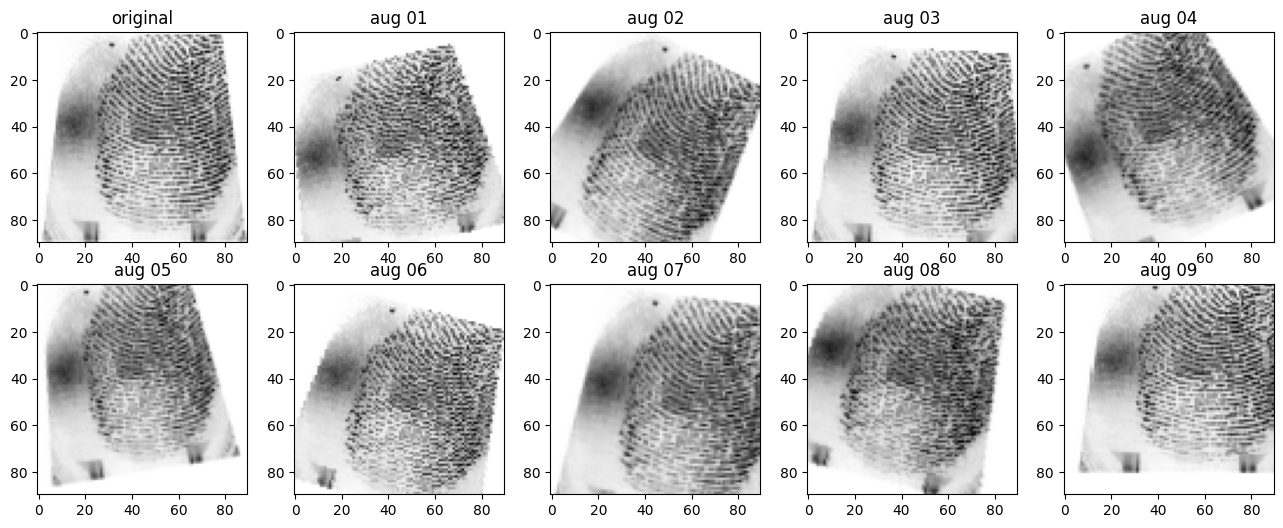

In [85]:
# Use index that actually exists in dataset (avoid index out of bounds)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
augs = [x_data[sample_idx]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
# Use index that actually exists in dataset (avoid index out of bounds)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
plt.imshow(x_data[sample_idx].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# enhacement

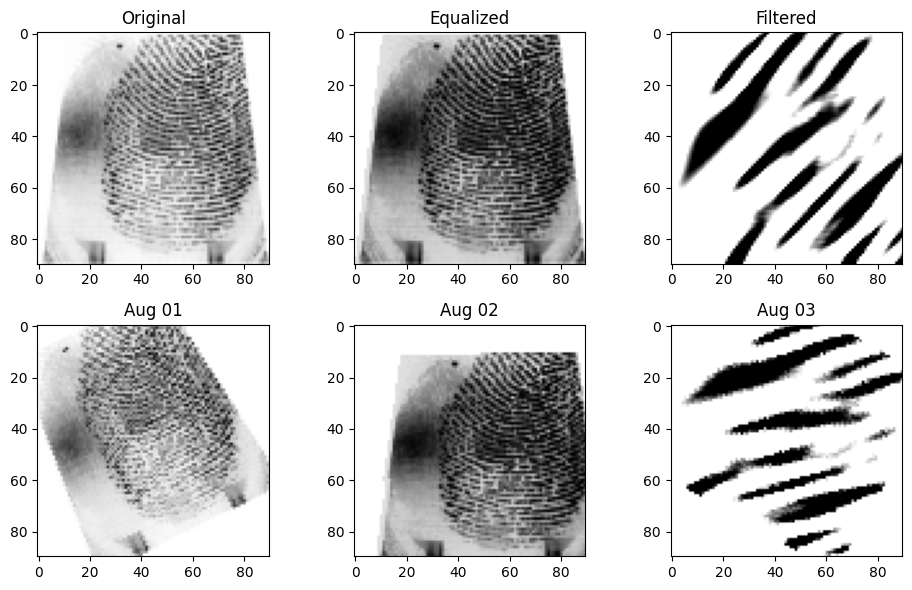

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

# Load the original image (use index that actually exists in dataset)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
original_image = x_data[sample_idx]

# Apply histogram equalization to enhance contrast
equalized_image = cv2.equalizeHist(original_image.squeeze())

# Define the parameters for Gabor filtering
ksize = (31, 31)  # Kernel size
sigma = 5.0  # Standard deviation of the Gaussian envelope
theta = np.pi / 4  # Orientation of the Gabor filter (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio
psi = 0.0  # Phase offset

# Create the Gabor filter
gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)

# Apply Gabor filtering
filtered_image = cv2.filter2D(equalized_image, cv2.CV_8UC3, gabor_kernel)

# Create augmentation sequence
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Blur images with a sigma of 0 to 0.5
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},  # Scale images to 90-110% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translate by -10 to +10 percent (per axis)
        rotate=(-30, 30),  # Rotate by -30 to +30 degrees
        order=[0, 1],  # Use nearest neighbor or bilinear interpolation (fast)
        cval=255  # If mode is constant, use a cval between 0 and 255
    )
], random_order=True)

# Apply augmentation to the images
enhanced_augs = seq.augment_images([original_image, equalized_image, filtered_image])

# Plot the original and augmented images
plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('Original')
plt.imshow(original_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 2)
plt.title('Equalized')
plt.imshow(equalized_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 3)
plt.title('Filtered')
plt.imshow(filtered_image.squeeze(), cmap='gray')

for i, aug in enumerate(enhanced_augs):
    plt.subplot(2, 5, i+6)
    plt.title('Aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()


In [87]:
# ============================================
# Create label_real_dict and x_real for Project-Data
# ============================================
# Important: x_real should only contain training set images to avoid data leakage
# This way, during training and validation, the model won't "see" validation set reference images
label_real_dict = {}
x_real_list = []
y_real_list = []
x_real_file_paths = []  # Store file paths for x_real images

# Use dictionary to track image index for each unique label
# key: label string, value: index in x_real
seen_labels = {}

# Create reference image set using only training set (avoid data leakage)
print("Creating reference image set (using only training set to avoid data leakage)...")
for i, label in enumerate(label_train):
    key = label.astype(str)
    key = ''.join(key).zfill(6)
    
    if key not in seen_labels:
        # Save first image for each unique label as reference
        seen_labels[key] = len(x_real_list)
        label_real_dict[key] = len(x_real_list)
        x_real_list.append(x_train[i])
        y_real_list.append(label)
        x_real_file_paths.append(train_file_paths[i])  # Save corresponding file path
    else:
        # If already exists, update dictionary to point to existing index
        label_real_dict[key] = seen_labels[key]

# Convert to numpy arrays
x_real = np.array(x_real_list, dtype=np.uint8)
y_real = np.array(y_real_list, dtype=np.int32)

print(f"Reference image set (x_real): {x_real.shape}")
print(f"Reference label set (y_real): {y_real.shape}")
print(f"Number of unique labels: {len(seen_labels)}")
print(f"label_real_dict size: {len(label_real_dict)}")

# Verify: Check if all labels in training set are in dictionary
def check_labels_in_dict(labels, label_dict, name):
    """Check if all labels are in dictionary"""
    keys = set()
    for label in labels:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        keys.add(key)
    
    missing_keys = keys - set(label_dict.keys())
    if missing_keys:
        print(f"Warning: {name} has {len(missing_keys)} labels not in label_real_dict")
        print(f"Example missing keys: {list(missing_keys)[:5]}")
        return False, missing_keys
    else:
        print(f"✓ All labels in {name} are in label_real_dict")
        return True, set()

# Check training set (must all be in dictionary)
train_ok, train_missing = check_labels_in_dict(label_train, label_real_dict, "Training set")

# If there are missing labels, add them from training set
if train_missing:
    print(f"\nFound {len(train_missing)} missing labels, adding from training set...")
    for label in label_train:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        if key in train_missing and key not in label_real_dict:
            idx = np.where((label_train == label).all(axis=1))[0]
            if len(idx) > 0:
                label_real_dict[key] = len(x_real_list)
                x_real_list.append(x_train[idx[0]])
                y_real_list.append(label)
                x_real_file_paths.append(train_file_paths[idx[0]])  # Save file path
                train_missing.remove(key)
    
    # Update x_real and y_real
    x_real = np.array(x_real_list, dtype=np.uint8)
    y_real = np.array(y_real_list, dtype=np.int32)
    
    # Update file paths if needed (should already be updated in the loop above)
    print(f"Added missing labels, updated x_real shape: {x_real.shape}")
    print(f"Updated label_real_dict size: {len(label_real_dict)}")
    
    # Verify training set again
    train_ok, _ = check_labels_in_dict(label_train, label_real_dict, "Training set")

# Check validation set (validation set may have some new labels not in training set, this is normal)
val_keys = set()
for label in label_val:
    key = label.astype(str)
    key = ''.join(key).zfill(6)
    val_keys.add(key)

val_missing = val_keys - set(label_real_dict.keys())
if val_missing:
    print(f"\nNote: Validation set has {len(val_missing)} labels not in training set (this is normal)")
    print(f"These labels may not be matchable during evaluation, but won't affect training process")
else:
    print(f"\n✓ All labels in validation set are in training set (can evaluate completely)")

Creating reference image set (using only training set to avoid data leakage)...
Reference image set (x_real): (488, 90, 90, 1)
Reference label set (y_real): (488, 4)
Number of unique labels: 488
label_real_dict size: 488
✓ All labels in Training set are in label_real_dict

Note: Validation set has 12 labels not in training set (this is normal)
These labels may not be matchable during evaluation, but won't affect training process


In [88]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True, **kwargs):
        'Initialization'
        super().__init__(**kwargs)  # Newer Keras versions require calling super().__init__()
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # Data augmentation (applied on-the-fly during training)
        # Note: This is "online augmentation" - images are augmented differently each time
        # The dataset size remains the same (1464), but each epoch sees different variations
        # This effectively increases data diversity without expanding the dataset
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            # Check if match_key is in dictionary, if not skip or use default value
            if match_key not in self.label_real_dict:
                # If key doesn't exist, randomly select one from dictionary
                print(f"Warning: Key '{match_key}' not in label_real_dict, using random key instead")
                match_key = random.choice(list(self.label_real_dict.keys()))

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        # Ensure return format is tuple and data types are correct
        x1_batch = (x1_batch.astype(np.float32) / 255.)
        x2_batch = (x2_batch.astype(np.float32) / 255.)
        y_batch = y_batch.astype(np.float32)
        return (x1_batch, x2_batch), y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [89]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

In [90]:

x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_10       │ (None, 22, 22,    │      9,568 │ input_layer_15[0… │
│ (Functional)        │ 32)               │            │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_5          │ (None, 22, 22,    │          0 │ functional_10[0]… │
│ (Subtract)          │ 32)               │            │ functional_10[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 22, 22,    │      9,248 │ subtract_5[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 11, 11,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 3872)      │          0 │ max_pooling2d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │    247,872 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 266,753 (1.02 MB)

 Trainable params: 266,753 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
history = model.fit(train_gen, epochs=60, validation_data=val_gen)

Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.5306 - loss: 0.6917Warning: Key '040000' not in label_real_dict, using random key instead
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - acc: 0.5310 - loss: 0.6917 - val_acc: 0.5188 - val_loss: 0.7067
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.5951 - loss: 0.6631Warning: Key '040000' not in label_real_dict, using random key instead
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - acc: 0.5956 - loss: 0.6630 - val_acc: 0.5938 - val_loss: 0.6745
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.6193 - loss: 0.6480Warning: Key '040000' not in label_real_dict, using random key instead
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.6196 - loss: 0.6478 - val_acc: 0.5646 - val_loss: 0.6792
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.6646 - loss: 0.6187Warning: Key '040000' not in label_real_dict, using random key instead
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.6643 - loss: 0.6187 - val_acc: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image File Paths
Input Image (from test set):
  Index in test set: 287
  Label: [287   0   0   0]
  File path: Project-Data/test/287_R0_4.bmp
  Absolute path: /Users/sohpie/Downloads/Fingerprint_Matching-master/Project-Data/test/287_R0_4.bmp

Matched Reference Image (from x_real):
  Index in x_real: 280
  Label: [287   0   0   0]
  Match key: 287000
  File path: Project-Data/train/287_R0_0.bmp
  Absolute path: /Users/sohpie/Downloads/Fingerprint_Matching-master/Project-Data/train/287_R0_0.bmp

Prediction score: 0.5116


/var/folders/7d/n5_y1thj0vgfvx7qbmy8lln80000gn/T/ipykernel_91043/1887776404.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))


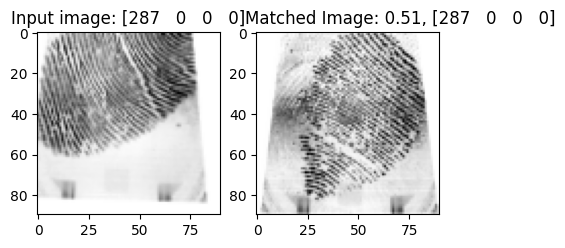

In [92]:

# new user fingerprint input (using test set)
# Ensure test set variables are defined (in case Cell 1 wasn't run)
if 'x_test' not in globals():
    x_test = None
    label_test = None
    test_file_paths = None

if x_test is None:
    print("Warning: Test set not loaded, using validation set instead")
    random_idx = random.randint(1, len(x_val))
    random_img = x_val[random_idx]
    random_label = label_val[random_idx]
    input_file_paths = val_file_paths
    data_source = "validation set"
else:
    random_idx = random.randint(1, len(x_test))
    random_img = x_test[random_idx]
    random_label = label_test[random_idx]
    input_file_paths = test_file_paths
    data_source = "test set"

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# Get file paths for both images
# Image 1: Input image from test set (or validation set if test set not available)
input_image_path = input_file_paths[random_idx]

# Image 2: Matched reference image from x_real
x_real_idx = label_real_dict[match_key]
reference_image_path = x_real_file_paths[x_real_idx]

# Print file paths
print("="*60)
print("Image File Paths")
print("="*60)
print(f"Input Image (from {data_source}):")
print(f"  Index in {data_source}: {random_idx}")
print(f"  Label: {random_label}")
print(f"  File path: {input_image_path}")
print(f"  Absolute path: {os.path.abspath(input_image_path)}")
print(f"\nMatched Reference Image (from x_real):")
print(f"  Index in x_real: {x_real_idx}")
print(f"  Label: {ry}")
print(f"  Match key: {match_key}")
print(f"  File path: {reference_image_path}")
print(f"  Absolute path: {os.path.abspath(reference_image_path)}")
print(f"\nPrediction score: {pred_rx[0][0]:.4f}")
print("="*60)

# unmatched image
# unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

# ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# uy = y_real[unmatch_idx]

# pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input image: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
# plt.subplot(1, 3, 3)
# plt.title('X: %.02f, %s' % (pred_ux, uy))
# plt.imshow(ux.squeeze(), cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image File Paths
Input Image (from test set):
  Index in test set: 162
  Label: [162   0   0   0]
  File path: Project-Data/test/162_R0_4.bmp
  Absolute path: /Users/sohpie/Downloads/Fingerprint_Matching-master/Project-Data/test/162_R0_4.bmp

Matched Reference Image (from x_real):
  Index in x_real: 158
  Label: [162   0   0   0]
  Match key: 162000
  File path: Project-Data/train/162_R0_0.bmp
  Absolute path: /Users/sohpie/Downloads/Fingerprint_Matching-master/Project-Data/train/162_R0_0.bmp

Prediction score: 0.4578


/var/folders/7d/n5_y1thj0vgfvx7qbmy8lln80000gn/T/ipykernel_91043/2838800137.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))


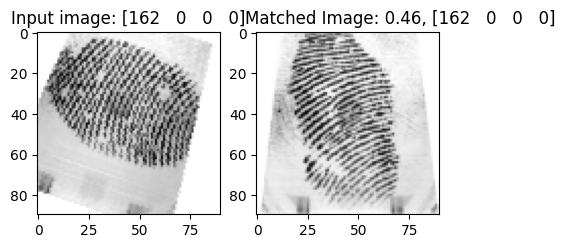

In [96]:
# new user fingerprint input (using test set)
# Ensure test set variables are defined (in case Cell 1 wasn't run)

random_idx = random.randint(1, len(x_test))
random_img = x_test[random_idx]
random_label = label_test[random_idx]
input_file_paths = test_file_paths
data_source = "test set"

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# Get file paths for both images
# Image 1: Input image from test set (or validation set if test set not available)
input_image_path = input_file_paths[random_idx]

# Image 2: Matched reference image from x_real
x_real_idx = label_real_dict[match_key]
reference_image_path = x_real_file_paths[x_real_idx]

# Print file paths
print("="*60)
print("Image File Paths")
print("="*60)
print(f"Input Image (from {data_source}):")
print(f"  Index in {data_source}: {random_idx}")
print(f"  Label: {random_label}")
print(f"  File path: {input_image_path}")
print(f"  Absolute path: {os.path.abspath(input_image_path)}")
print(f"\nMatched Reference Image (from x_real):")
print(f"  Index in x_real: {x_real_idx}")
print(f"  Label: {ry}")
print(f"  Match key: {match_key}")
print(f"  File path: {reference_image_path}")
print(f"  Absolute path: {os.path.abspath(reference_image_path)}")
print(f"\nPrediction score: {pred_rx[0][0]:.4f}")
print("="*60)

# unmatched image
# unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

# ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# uy = y_real[unmatch_idx]

# pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input image: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
# plt.subplot(1, 3, 3)
# plt.title('X: %.02f, %s' % (pred_ux, uy))
# plt.imshow(ux.squeeze(), cmap='gray')

In [97]:
# ============================================
# Calculate Evaluation Metrics: IMR, FMR, FNMR, EER, etc.
# ============================================
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import time

def calculate_fingerprint_metrics(model, x_val, label_val, x_real, label_real_dict, 
                                   num_samples=500, batch_size=32):
    """
    Calculate evaluation metrics for fingerprint recognition system
    
    Parameters:
        model: Trained model
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference image set
        label_real_dict: Dictionary mapping labels to reference images
        num_samples: Number of samples for evaluation
        batch_size: Batch size
    
    Returns:
        metrics: Dictionary containing various metrics
    """
    print("Starting to calculate evaluation metrics...")
    print(f"Using {num_samples} samples for evaluation")
    
    # Limit number of samples to speed up calculation
    num_samples = min(num_samples, len(x_val))
    indices = np.random.choice(len(x_val), num_samples, replace=False)
    x_test = x_val[indices]
    label_test = label_val[indices]
    
    # Store matching scores and true labels
    genuine_scores = []  # Genuine match scores
    impostor_scores = []  # Impostor match scores
    
    print("Calculating matching scores...")
    start_time = time.time()
    
    # Calculate genuine match scores (same fingerprint)
    for i in range(num_samples):
        img1 = x_test[i].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
        label1 = label_test[i]
        
        # Find corresponding reference image
        match_key = label1.astype(str)
        match_key = ''.join(match_key).zfill(6)
        
        if match_key in label_real_dict:
            img2 = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
            score = model.predict([img1, img2], verbose=0)[0][0]
            genuine_scores.append(score)
        
        if (i + 1) % 50 == 0:
            print(f"  Processing progress: {i+1}/{num_samples}")
    
    # Calculate impostor match scores (different fingerprints)
    print("Calculating impostor match scores...")
    num_impostor = min(num_samples, len(label_real_dict) * 10)  # Limit number of impostor matches
    
    for i in range(num_impostor):
        # Randomly select a test image
        idx1 = np.random.randint(0, num_samples)
        img1 = x_test[idx1].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
        label1 = label_test[idx1]
        
        # Randomly select a different reference image
        while True:
            unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
            label1_key = label1.astype(str)
            label1_key = ''.join(label1_key).zfill(6)
            if unmatch_key != label1_key:
                break
        
        img2 = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
        score = model.predict([img1, img2], verbose=0)[0][0]
        impostor_scores.append(score)
        
        if (i + 1) % 50 == 0:
            print(f"  Processing progress: {i+1}/{num_impostor}")
    
    elapsed_time = time.time() - start_time
    print(f"\nCalculation complete, elapsed time: {elapsed_time:.2f} seconds")
    
    genuine_scores = np.array(genuine_scores)
    impostor_scores = np.array(impostor_scores)
    
    print(f"\nGenuine match score statistics:")
    print(f"  Count: {len(genuine_scores)}")
    print(f"  Mean: {genuine_scores.mean():.4f}")
    print(f"  Std: {genuine_scores.std():.4f}")
    print(f"  Min: {genuine_scores.min():.4f}")
    print(f"  Max: {genuine_scores.max():.4f}")
    
    print(f"\nImpostor match score statistics:")
    print(f"  Count: {len(impostor_scores)}")
    print(f"  Mean: {impostor_scores.mean():.4f}")
    print(f"  Std: {impostor_scores.std():.4f}")
    print(f"  Min: {impostor_scores.min():.4f}")
    print(f"  Max: {impostor_scores.max():.4f}")
    
    # Calculate metrics at different thresholds
    thresholds = np.arange(0.0, 1.01, 0.01)
    fmr_list = []  # False Match Rate
    fnmr_list = []  # False Non-Match Rate
    
    for threshold in thresholds:
        # FMR: Proportion of impostor matches incorrectly accepted
        fmr = np.sum(impostor_scores >= threshold) / len(impostor_scores)
        fmr_list.append(fmr)
        
        # FNMR: Proportion of genuine matches incorrectly rejected
        fnmr = np.sum(genuine_scores < threshold) / len(genuine_scores)
        fnmr_list.append(fnmr)
    
    fmr_list = np.array(fmr_list)
    fnmr_list = np.array(fnmr_list)
    
    # Calculate EER (Equal Error Rate)
    # EER is the error rate when FMR and FNMR are equal
    diff = np.abs(fmr_list - fnmr_list)
    eer_idx = np.argmin(diff)
    eer_threshold = thresholds[eer_idx]
    eer = (fmr_list[eer_idx] + fnmr_list[eer_idx]) / 2
    
    # Calculate IMR (Identification Match Rate)
    # Use EER threshold as decision threshold
    correct_matches = np.sum(genuine_scores >= eer_threshold)
    imr = correct_matches / len(genuine_scores)
    
    # Calculate ROC curve and AUC
    all_scores = np.concatenate([genuine_scores, impostor_scores])
    all_labels = np.concatenate([np.ones(len(genuine_scores)), np.zeros(len(impostor_scores))])
    fpr, tpr, roc_thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Calculate accuracy, precision, recall using EER threshold
    predictions = (all_scores >= eer_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    precision = precision_score(all_labels, predictions)
    recall = recall_score(all_labels, predictions)
    f1 = f1_score(all_labels, predictions)
    
    metrics = {
        'genuine_scores': genuine_scores,
        'impostor_scores': impostor_scores,
        'thresholds': thresholds,
        'fmr_list': fmr_list,
        'fnmr_list': fnmr_list,
        'eer': eer,
        'eer_threshold': eer_threshold,
        'imr': imr,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return metrics

# Calculate evaluation metrics
metrics = calculate_fingerprint_metrics(
    model, x_val, label_val, x_real, label_real_dict, 
    num_samples=min(500, len(x_val)), batch_size=32
)

# Print main metrics
print("\n" + "="*60)
print("Evaluation Metrics Results")
print("="*60)
print(f"IMR (Identification Match Rate): {metrics['imr']:.4f} ({metrics['imr']*100:.2f}%)")
print(f"EER (Equal Error Rate): {metrics['eer']:.4f} ({metrics['eer']*100:.2f}%)")
print(f"EER Threshold: {metrics['eer_threshold']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")
print(f"Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
print(f"Recall: {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
print(f"F1 Score: {metrics['f1']:.4f}")
print("="*60)


Starting to calculate evaluation metrics...
Using 500 samples for evaluation
Calculating matching scores...
  Processing progress: 50/500
  Processing progress: 100/500
  Processing progress: 150/500
  Processing progress: 200/500
  Processing progress: 250/500
  Processing progress: 300/500
  Processing progress: 350/500
  Processing progress: 400/500
  Processing progress: 450/500
  Processing progress: 500/500
Calculating impostor match scores...
  Processing progress: 50/500
  Processing progress: 100/500
  Processing progress: 150/500
  Processing progress: 200/500
  Processing progress: 250/500
  Processing progress: 300/500
  Processing progress: 350/500
  Processing progress: 400/500
  Processing progress: 450/500
  Processing progress: 500/500

Calculation complete, elapsed time: 23.58 seconds

Genuine match score statistics:
  Count: 488
  Mean: 0.6017
  Std: 0.2488
  Min: 0.0037
  Max: 0.9998

Impostor match score statistics:
  Count: 500
  Mean: 0.2490
  Std: 0.2739
  Min: 

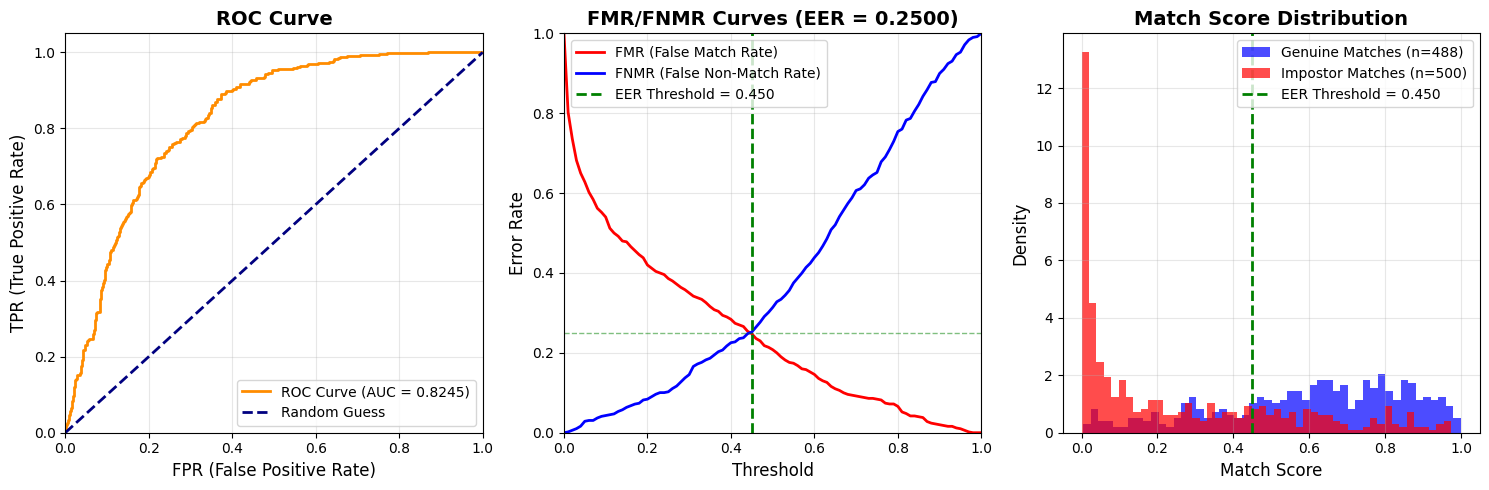


Detailed Statistics

Performance at EER threshold (0.4500):
  FMR (False Match Rate): 0.2480 (24.80%)
  FNMR (False Non-Match Rate): 0.2520 (25.20%)
  IMR (Identification Match Rate): 0.7480 (74.80%)


In [98]:
# ============================================
# Visualize Evaluation Metrics: ROC Curve, FMR/FNMR Curves, Score Distribution
# ============================================

# 1. Plot ROC curve
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(metrics['fpr'], metrics['tpr'], color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (False Positive Rate)', fontsize=12)
plt.ylabel('TPR (True Positive Rate)', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# 2. Plot FMR/FNMR curves
plt.subplot(1, 3, 2)
plt.plot(metrics['thresholds'], metrics['fmr_list'], 'r-', lw=2, label='FMR (False Match Rate)')
plt.plot(metrics['thresholds'], metrics['fnmr_list'], 'b-', lw=2, label='FNMR (False Non-Match Rate)')
plt.axvline(x=metrics['eer_threshold'], color='green', linestyle='--', lw=2, 
            label=f'EER Threshold = {metrics["eer_threshold"]:.3f}')
plt.axhline(y=metrics['eer'], color='green', linestyle='--', lw=1, alpha=0.5)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title(f'FMR/FNMR Curves (EER = {metrics["eer"]:.4f})', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# 3. Plot score distribution histogram
plt.subplot(1, 3, 3)
plt.hist(metrics['genuine_scores'], bins=50, alpha=0.7, color='blue', 
         label=f'Genuine Matches (n={len(metrics["genuine_scores"])})', density=True)
plt.hist(metrics['impostor_scores'], bins=50, alpha=0.7, color='red', 
         label=f'Impostor Matches (n={len(metrics["impostor_scores"])})', density=True)
plt.axvline(x=metrics['eer_threshold'], color='green', linestyle='--', lw=2, 
            label=f'EER Threshold = {metrics["eer_threshold"]:.3f}')
plt.xlabel('Match Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Match Score Distribution', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("Detailed Statistics")
print("="*60)
print(f"\nPerformance at EER threshold ({metrics['eer_threshold']:.4f}):")
print(f"  FMR (False Match Rate): {metrics['fmr_list'][int(metrics['eer_threshold']*100)]:.4f} ({metrics['fmr_list'][int(metrics['eer_threshold']*100)]*100:.2f}%)")
print(f"  FNMR (False Non-Match Rate): {metrics['fnmr_list'][int(metrics['eer_threshold']*100)]:.4f} ({metrics['fnmr_list'][int(metrics['eer_threshold']*100)]*100:.2f}%)")
print(f"  IMR (Identification Match Rate): {metrics['imr']:.4f} ({metrics['imr']*100:.2f}%)")
print("="*60)
